In [73]:
!pip install python-doctr
!pip install jiwer


# Import Library

In [74]:
# ——— Core Python ————————————————————————————————
import ast
import math
import os
import random
import re
import shutil
import time
import warnings
from collections import Counter
from pathlib import Path

# ——— Numerical / Data ————————————————————————————
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# ——— Visualization ——————————————————————————————
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# ——— PyTorch ————————————————————————————————
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# ——— TorchMetrics ——————————————————————————————
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ——— TorchVision ———————————————————————————————
import torchvision
from torchvision import models, transforms as T
from torchvision.models.detection import (
    FasterRCNN_MobileNet_V3_Large_320_FPN_Weights,
    FasterRCNN_ResNet50_FPN_Weights,
    fasterrcnn_mobilenet_v3_large_320_fpn,
    fasterrcnn_resnet50_fpn,
)
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import roi_align

# ——— External Libraries ——————————————————————————
from doctr.datasets import FUNSD
import editdistance
from jiwer import wer  # JiWER library for Word Error Rate calculation

# ——— Progress Bar ——————————————————————————————
from tqdm.auto import tqdm


# Data

In [7]:
full_dataset = FUNSD(train=True, download=True)

  0%|          | 0/16838830 [00:00<?, ?it/s]

Preparing and Loading FUNSD: 100%|██████████| 149/149 [00:00<00:00, 1938.45it/s]


## Detection

In [8]:
class FUNSDDetectionDataset(Dataset):
    def __init__(self, doctr_dataset, split="train", split_ratio=0.8, transform=None):
        assert split in ["train", "test"]
        self.transform = transform  
        self.samples = doctr_dataset
        self.resize_size = (640, 640)  

        total = len(self.samples)
        random.seed(42)
        indices = list(range(total))
        random.shuffle(indices)

        split_point = int(total * split_ratio)
        if split == "train":
            self.indices = indices[:split_point]
        else:
            self.indices = indices[split_point:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, target = self.samples[self.indices[idx]]

        if isinstance(img, torch.Tensor):
            _, h, w = img.shape
        else:
            w, h = img.size

        boxes = []
        labels = []

        for box, label_text in zip(target['boxes'], target['labels']):
            if label_text.strip() == "":
                continue

            xmin, ymin, xmax, ymax = box
            boxes.append([
                xmin * w,
                ymin * h,
                xmax * w,
                ymax * h
            ])
            labels.append(1)

        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        target_w, target_h = self.resize_size
        scale_x = target_w / w
        scale_y = target_h / h

        resized_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            resized_boxes.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])


        if isinstance(img, torch.Tensor):
            img = T.ToPILImage()(img)  # Convert tensor -> PIL để resize
        img = img.resize(self.resize_size)

        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)

        target = {
            'boxes': torch.tensor(resized_boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

        return img, target


In [9]:
def det_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(targets)

In [10]:
 def visualize_detection_sample(dataset, idx=None, figsize=(12, 12), box_color='r', box_thickness=2):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    image, target = dataset[idx]
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    if image.max() <= 1.0:
        image = (image * 255).astype('uint8')

    boxes = target['boxes'].cpu().numpy()

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)
    print(image.shape)

    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                                  linewidth=box_thickness, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Sample index: {idx} - {len(boxes)} boxes", fontsize=15)
    plt.axis('off')
    plt.show()


In [11]:
train_det_dataset = FUNSDDetectionDataset(full_dataset, split="train")
test_det_dataset = FUNSDDetectionDataset(full_dataset, split="test")
train_det_loader = DataLoader(train_det_dataset, batch_size=8, shuffle=True, collate_fn=det_collate_fn)
test_det_loader = DataLoader(test_det_dataset, batch_size=8, shuffle=False, collate_fn=det_collate_fn)

(640, 640, 3)


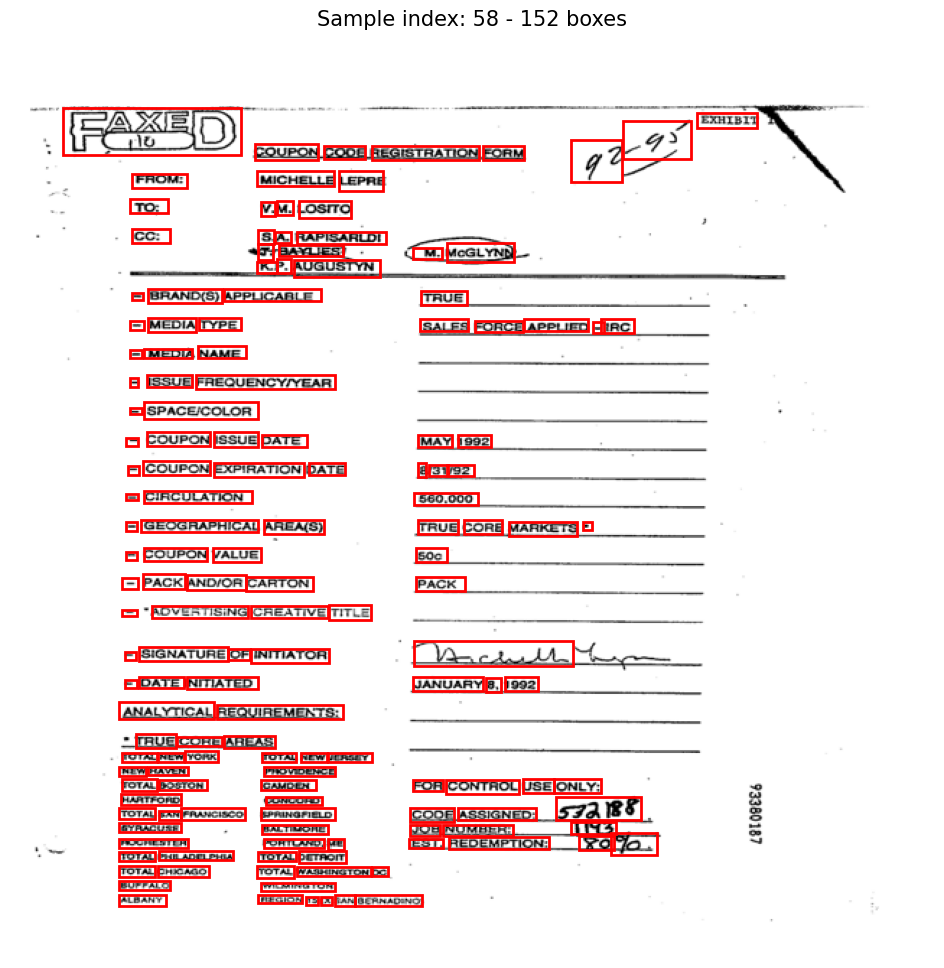

In [13]:
visualize_detection_sample(train_det_dataset)

## Recognization

In [14]:
vocab = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '.:/"
special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
char2idx = {tok: i for i, tok in enumerate(special_tokens)}
char2idx.update({ch: i + len(special_tokens) for i, ch in enumerate(vocab)})
idx2char = {i: ch for ch, i in char2idx.items()}

In [16]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage

class FUNSDRecognitionDataset(Dataset):
    def __init__(self, doctr_dataset, split="train", split_ratio=0.8, transform=None, char2idx=None, max_length=100):
        assert split in ["train", "test"]
        self.transform = transform
        self.char2idx = char2idx
        self.max_length = max_length
        self.samples = doctr_dataset


        total = len(self.samples)
        random.seed(42)
        indices = list(range(total))
        random.shuffle(indices)

        split_point = int(total * split_ratio)
        if split == "train":
            self.indices = indices[:split_point]
        else:
            self.indices = indices[split_point:]


        self.flattened = []
        for img_idx in self.indices:
            img, target = self.samples[img_idx]
            for ann_idx, label in enumerate(target['labels']):
                self.flattened.append((img_idx, ann_idx))


        if self.transform is None:
            self.transform = Compose([
                Resize((224, 224)),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
            ])

        self.to_pil = ToPILImage()

    def text_to_sequence(self, text):
        tokens = [self.char2idx.get("<SOS>")]
        for ch in text:
            tokens.append(self.char2idx.get(ch, self.char2idx["<UNK>"]))
        tokens.append(self.char2idx.get("<EOS>"))
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
            tokens[-1] = self.char2idx["<EOS>"]
        return torch.tensor(tokens, dtype=torch.long)

    def __len__(self):
        return len(self.flattened)

    def __getitem__(self, idx):
        img_idx, ann_idx = self.flattened[idx]
        img, target = self.samples[img_idx]

   
        if isinstance(img, torch.Tensor):
            C, H, W = img.shape
            pil_img = None
        else:
            W, H = img.size
            pil_img = img

        box = target['boxes'][ann_idx]
        xmin = int(box[0] * W)
        ymin = int(box[1] * H)
        xmax = int(box[2] * W)
        ymax = int(box[3] * H)

        if pil_img is not None:
            cropped = pil_img.crop((xmin, ymin, xmax, ymax))
        else:
            cropped = img[:, ymin:ymax, xmin:xmax]
            cropped = self.to_pil(cropped)

        cropped = self.transform(cropped)
        text = target['labels'][ann_idx]
        label_seq = self.text_to_sequence(text)

        return cropped, label_seq


In [17]:
def reg_collate_fn(batch):
    images, labels = zip(*batch)
    B = len(images)
    C = images[0].shape[0]

    heights = [img.shape[1] for img in images]
    widths  = [img.shape[2] for img in images]
    H_max = max(heights)
    W_max = max(widths)

    batch_imgs = torch.zeros(B, C, H_max, W_max, dtype=images[0].dtype)
    for i, img in enumerate(images):
        c, h, w = img.shape
        batch_imgs[i, :, :h, :w] = img

    label_lengths = [seq.numel() for seq in labels]
    L_max = max(label_lengths)
    pad_token = char2idx["<PAD>"]
    batch_labels = torch.full((B, L_max), pad_token, dtype=torch.long)
    for i, seq in enumerate(labels):
        batch_labels[i, :label_lengths[i]] = seq

    return batch_imgs, batch_labels, widths, heights, label_lengths


In [18]:
train_reg_dataset = FUNSDRecognitionDataset(full_dataset, split="train", char2idx=char2idx, max_length=100)
test_reg_dataset = FUNSDRecognitionDataset(full_dataset, split="test", char2idx=char2idx, max_length=100)
train_reg_loader = DataLoader(train_reg_dataset, batch_size=32, shuffle=True, collate_fn=reg_collate_fn)
test_reg_loader = DataLoader(test_reg_dataset, batch_size=32, shuffle=False, collate_fn=reg_collate_fn)

Recognition batch:
Image tensor shape: torch.Size([32, 3, 224, 224])
Label tensor shape: torch.Size([32, 14])
Original widths : [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Original heights: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Label lengths   : [9, 13, 12, 5, 8, 9, 10, 10, 13, 4, 12, 10, 10, 7, 4, 5, 6, 4, 5, 11, 10, 6, 5, 14, 4, 4, 4, 4, 4, 10, 4, 10]

Sample 1:
Decoded text: Project


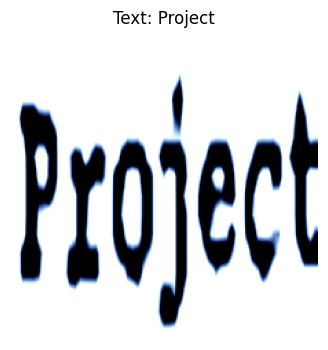


Sample 2:
Decoded text: Recommended


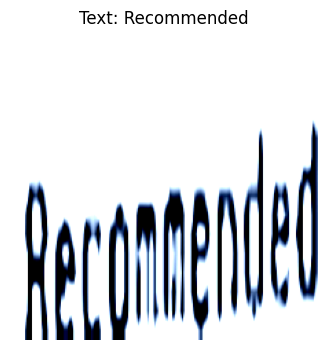


Sample 3:
Decoded text: INITIATION


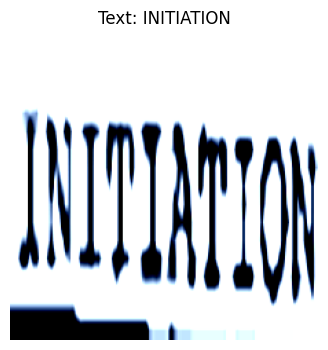


Sample 4:
Decoded text: <UNK>14


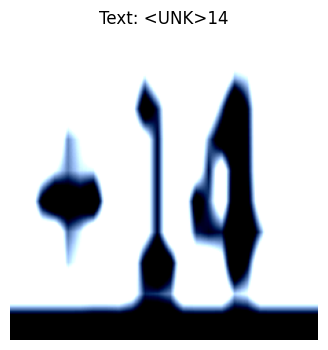


Sample 5:
Decoded text: AGENCY


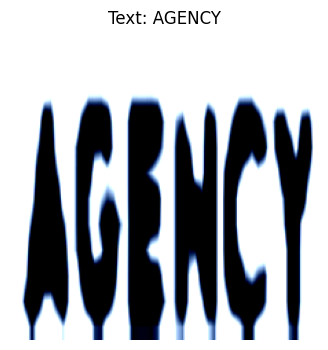


Sample 6:
Decoded text: Booklet


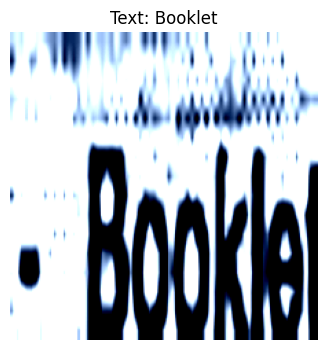


Sample 7:
Decoded text: 923<UNK>9208


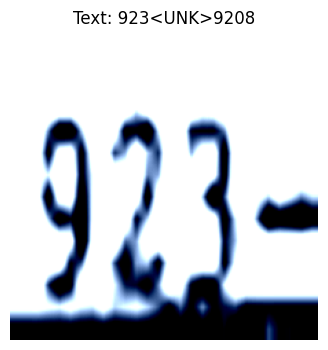


Sample 8:
Decoded text: COMPOUND


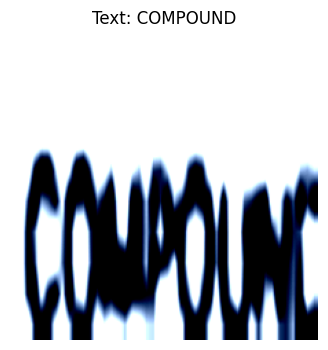

In [19]:
import matplotlib.pyplot as plt

imgs, labels, widths, heights, label_lengths = next(iter(train_reg_loader))

print("Recognition batch:")
print("Image tensor shape:", imgs.shape)      # (B, C, H_max, W_max)
print("Label tensor shape:", labels.shape)    # (B, max_seq_len)
print("Original widths :", widths)            # list[int]
print("Original heights:", heights)           # list[int]
print("Label lengths   :", label_lengths)     # list[int]

for i in range(min(8, imgs.size(0))):
    seq = labels[i, :label_lengths[i]]
    decoded = ''.join([
        idx2char[idx.item()]
        for idx in seq
        if idx.item() not in (char2idx["<PAD>"], char2idx["<SOS>"], char2idx["<EOS>"])
    ])

    print(f"\nSample {i+1}:")
    print("Decoded text:", decoded)

    img_tensor = imgs[i] 
    w, h = widths[i], heights[i]

    img_np = img_tensor.permute(1, 2, 0).numpy()  
    img_crop = img_np[:h, :w, :]                 

    plt.figure(figsize=(w / h * 4, 4))
    plt.imshow(img_crop)
    plt.title(f"Text: {decoded}")
    plt.axis('off')
    plt.show()


# Model and Training

## Detect 

In [20]:
class TextDetectorModel(torch.nn.Module):
    def __init__(self, num_classes: int = 2, pretrained: bool = True):
        super().__init__()

        if pretrained:
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        else:
            weights = None

        self.model = fasterrcnn_resnet50_fpn(weights=weights)
        in_channels = self.model.roi_heads.box_predictor.cls_score.in_features

        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_channels, num_classes)

    def forward(self, images, targets=None):
        if self.training:
            return self.model(images, targets)
        else:
            return self.model(images)

---

In [21]:
def train_detector(train_dataset, batch_size=4, num_epochs=30, lr=1e-4, 
                   checkpoint_dir="checkpoints", log_dir="tensorboard_logs",
                   resume_path=None, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, collate_fn=det_collate_fn)

    model = TextDetectorModel(num_classes=2, pretrained=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    best_loss, start_epoch = float('inf'), 0

    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        best_loss = ckpt.get('best_loss', float('inf'))
        start_epoch = ckpt.get('epoch', 0)

    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", colour='cyan')
        loss_list = []

        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            losses = model(images, targets)
            loss = sum(losses.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            mean_loss = np.mean(loss_list)
            pbar.set_postfix(loss=mean_loss)
            writer.add_scalar("Train/Loss", mean_loss, epoch * len(train_loader))

        epoch_loss = np.mean(loss_list)
        print(f"Epoch {epoch+1}/{num_epochs} ∘ Average Train Loss: {epoch_loss:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_loss": best_loss
            }, os.path.join(checkpoint_dir, "best.pt"))
            print(f"Saved best checkpoint with Train Loss = {best_loss:.4f}")



---

In [26]:
def test_detector_from_dataset(model_class, checkpoint_path, dataset, num_samples=5, conf_threshold=0.1):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model = model_class(num_classes=2)
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(device).eval()

    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img_tensor, _ = dataset[idx]  
        img = img_tensor.unsqueeze(0).to(device)  

        with torch.no_grad():
            output = model(img)[0]

        img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype('uint8')
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # OpenCV dùng BGR

       
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score >= conf_threshold:
                x1, y1, x2, y2 = map(int, box.tolist())
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(
                    img_np,
                    f"text {score:.2f}",
                    (x1, max(y1 - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 0),
                    1
                )

        # Hiển thị
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,8))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"Sample idx: {idx}")
        plt.show()


---

In [ ]:
# if __name__ == "__main__":
#     train_detector(
#         train_det_dataset,
#         batch_size=8,
#         num_epochs=40,
#         lr=1e-4,
#         checkpoint_dir="checkpoints_detect",
#         log_dir="logs_detect",
#         resume_path=None,                 
#         num_workers=0
#     )


/tmp/ipykernel_31/3243809929.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


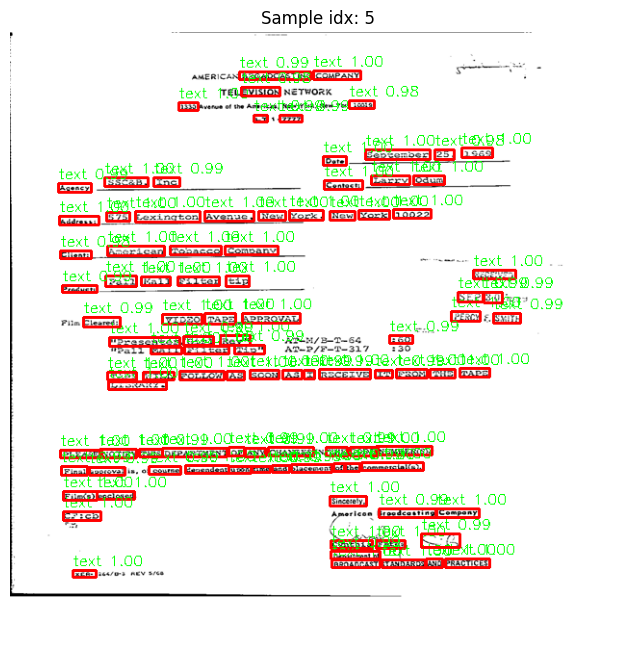

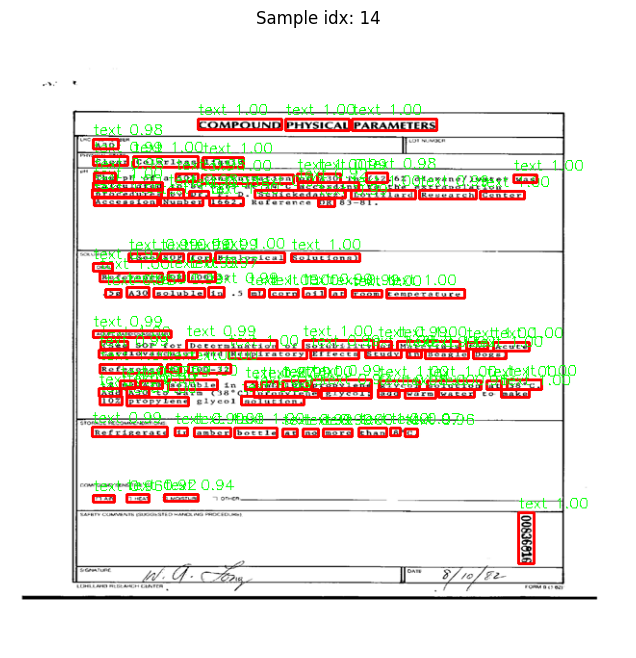

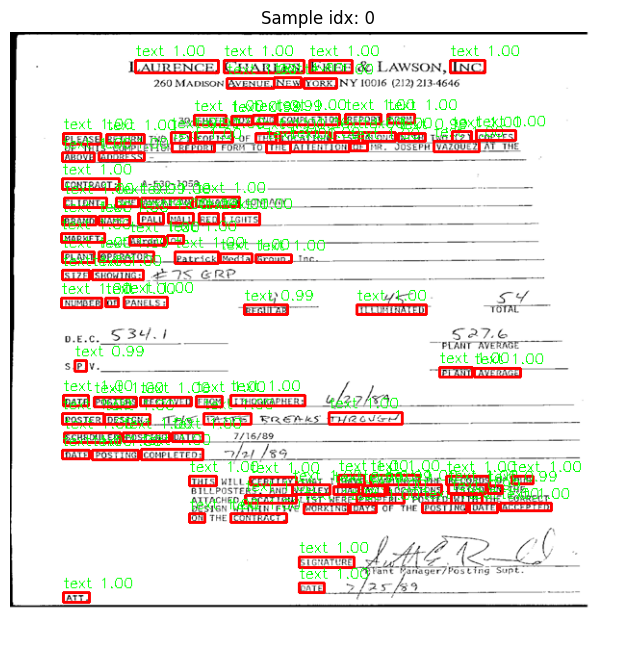

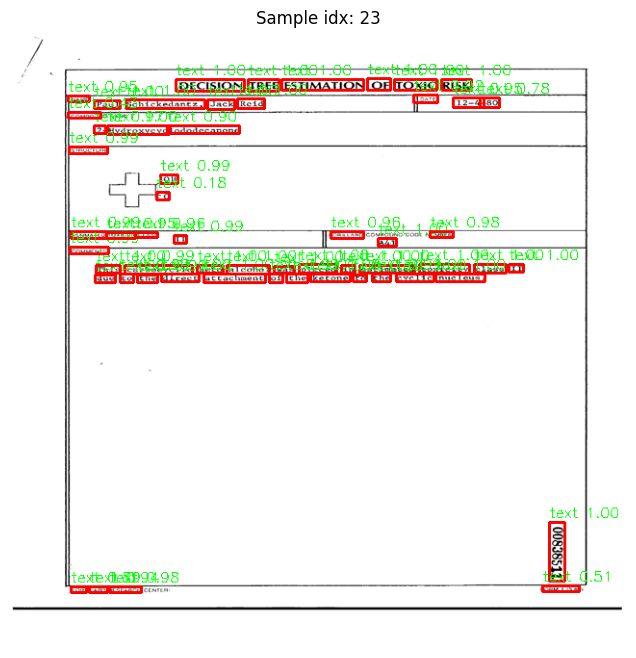

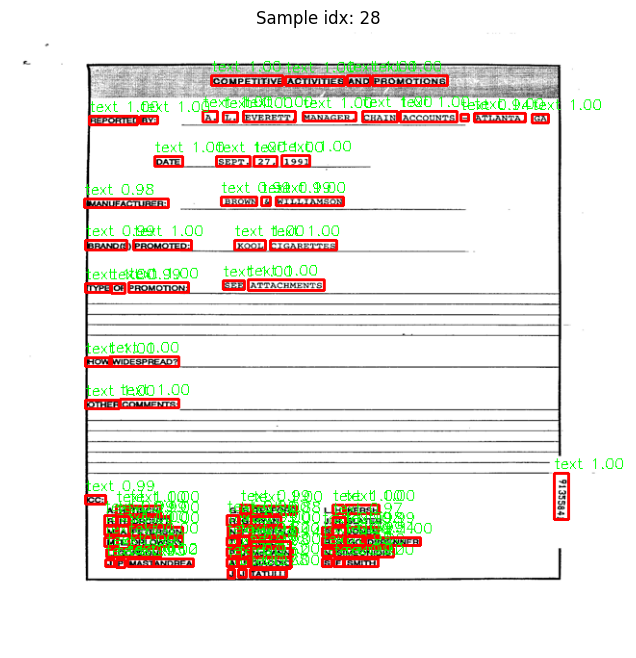

In [28]:

test_detector_from_dataset(TextDetectorModel, "/kaggle/input/funsd_model/pytorch/default/1/funsd_model/det.pt", test_det_dataset, num_samples=5, conf_threshold=0.1)


## Regconize

In [29]:
class CNNPatchEmbedding(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.proj = nn.Conv2d(512, embed_dim, kernel_size=1)

    def forward(self, x): 
        x = self.backbone(x)  
        x = self.proj(x)      
        B, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)  
        return x

In [30]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None):
        tgt2 = self.self_attn(self.norm1(tgt), self.norm1(tgt), self.norm1(tgt), attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout(tgt2)

        tgt2 = self.cross_attn(self.norm2(tgt), memory, memory)[0]
        tgt = tgt + self.dropout(tgt2)

        tgt2 = self.ffn(self.norm3(tgt))
        tgt = tgt + self.dropout(tgt2)

        return tgt


In [31]:
class ImageToTextRecognizer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, ff_dim=256, num_layers=2, max_len=100, dropout=0.3):
        super().__init__()
        self.encoder = CNNPatchEmbedding(embed_dim)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        self.decoder = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.output_proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, images, tgt_seq, tgt_mask=None):
        memory = self.encoder(images)  # [B, S, C]
        tgt_emb = self.token_embedding(tgt_seq) + self.pos_embedding[:, :tgt_seq.size(1), :]  # [B, T, C]

        for block in self.decoder:
            tgt_emb = block(tgt_emb, memory, tgt_mask=tgt_mask)

        output = self.output_proj(self.norm(tgt_emb)) 
        return output


In [32]:
def generate_square_subsequent_mask(sz, device="cpu"):
    return torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)


---

In [33]:
def generate_tgt_input_and_output(label_seq, pad_idx):
    tgt_input = label_seq[:, :-1] 
    tgt_output = label_seq[:, 1:]  
    return tgt_input, tgt_output


In [35]:
def train_recognizer(model, train_dataset,
                     batch_size=32, num_epochs=20, lr=1e-3,
                     pad_idx=0, checkpoint_dir="checkpoints_reg"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    os.makedirs(checkpoint_dir, exist_ok=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=reg_collate_fn
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, batch in enumerate(pbar):
            images, labels, *_ = batch
            images = images.to(device)
            labels = labels.to(device)

            tgt_input, tgt_output = generate_tgt_input_and_output(labels, pad_idx)
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1), device=device)

            logits = model(images, tgt_input, tgt_mask)
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_output.reshape(-1)
            )

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            pbar.set_postfix(loss=np.mean(epoch_loss))

        mean_loss = np.mean(epoch_loss)
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best.pt"))
            print(f"Saved best checkpoint with Train Loss = {best_loss:.4f}")

        print(f"Epoch {epoch+1}: Average Loss = {mean_loss:.6f}")


---

In [37]:
def greedy_decode(model, image, char2idx, idx2char, max_len=100, sos_token="<SOS>", eos_token="<EOS>"):
    device = next(model.parameters()).device
    model.eval()

    sos_idx = char2idx[sos_token]
    eos_idx = char2idx[eos_token]

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  
        memory = model.encoder(image) 

        output = [sos_idx]
        for _ in range(max_len):
            tgt_seq = torch.tensor(output, dtype=torch.long, device=device).unsqueeze(0)  
            tgt_mask = generate_square_subsequent_mask(tgt_seq.size(1), device=device)
            logits = model(image, tgt_seq, tgt_mask)  
            next_token = logits[0, -1].argmax().item()
            if next_token == eos_idx:
                break
            output.append(next_token)

    return ''.join([idx2char[idx] for idx in output[1:]])  # bỏ <SOS>


In [40]:
def test_recognizer_from_dataset( model_class, checkpoint_path, dataset, char2idx, idx2char, num_samples=5, max_len=100, transform=None,):
    
    to_pil_image = ToPILImage()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 
    model = model_class(vocab_size=len(char2idx))
    try:
        ckpt = torch.load(checkpoint_path, map_location=device, weights_only=True)
    except TypeError:
        ckpt = torch.load(checkpoint_path, map_location=device)

    if isinstance(ckpt, dict):
        if "model_state_dict" in ckpt:
            state = ckpt["model_state_dict"]
        elif "state_dict" in ckpt:
            state = ckpt["state_dict"]
        else:
            state = ckpt
    else:
        state = ckpt

    model.load_state_dict(state)
    model.to(device).eval()


    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        img_crop, label_seq = dataset[idx]
        if not isinstance(img_crop, torch.Tensor):
            img_t = transform(img_crop).unsqueeze(0).to(device)
        else:
            img_t = img_crop.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_text = greedy_decode(model, img_t[0], char2idx, idx2char, max_len)

  
        gt_text = ""
        for token in label_seq:
            ch = idx2char.get(token.item(), "")
            if ch not in ["<SOS>", "<EOS>", "<PAD>"]:
                gt_text += ch


        vis = img_t[0].cpu()


        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        vis = vis * std + mean
        vis = torch.clamp(vis, 0, 1)
        # -----------------------

        vis = to_pil_image(vis)

        plt.figure(figsize=(4,4))
        plt.imshow(vis)
        plt.axis("off")
        plt.title(f"Idx {idx} — Pred: {pred_text}\nGT: {gt_text}")
        plt.show()


---

In [ ]:
# train_reg_dataset = TextRecognitionDataset(
#      image_dir='/kaggle/working/train',
#      annot_csv='/kaggle/working/train.csv',
#      char2idx=char2idx
#  )


In [ ]:
 # model = ImageToTextRecognizer(vocab_size=len(char2idx))
 # train_recognizer(
 #     model=model,
 #     train_dataset=train_reg_dataset,     # recognition dataset
 #     batch_size=16,
 #     num_epochs=20,
 #     lr=1e-4,
 #     pad_idx=char2idx["<PAD>"]
 # )


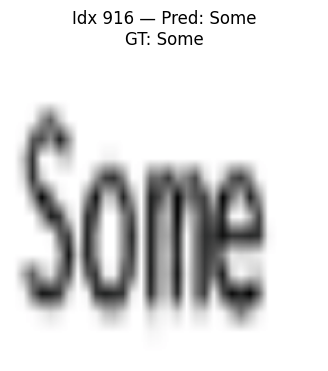

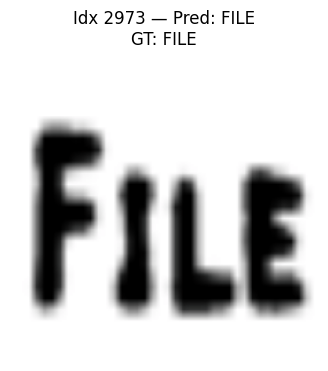

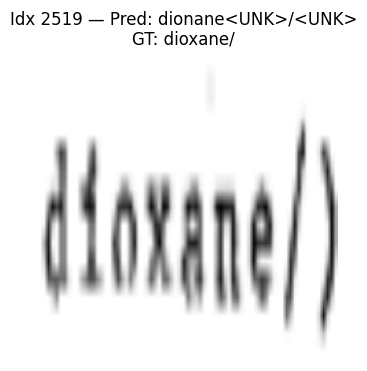

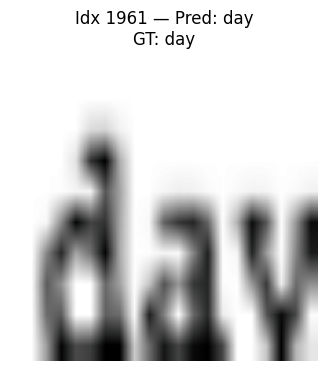

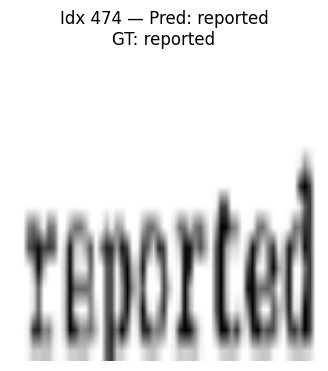

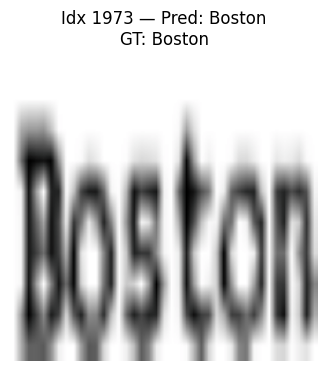

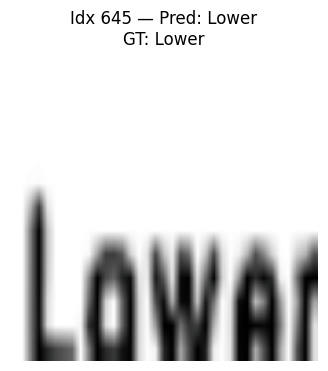

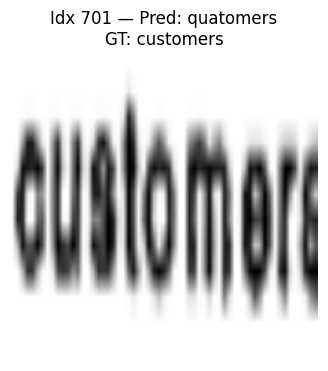

In [42]:
test_recognizer_from_dataset(
    ImageToTextRecognizer,
    "/kaggle/input/funsd_model/pytorch/default/1/funsd_model/reg_2.pt",
    test_reg_dataset,
    char2idx,
    idx2char,
    num_samples=8,
    max_len=100
)

# Test

In [59]:
def run_ocr_pipeline_from_image(image, char2idx, idx2char, detect_threshold=0.5, detect_ckpt_path=None, recognize_ckpt_path=None, detect_model=None, recognize_model=None): 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if detect_model is None:
        if detect_ckpt_path is None:
            raise ValueError("Either detect_model or detect_ckpt_path must be provided.")
        detect_model = TextDetectorModel(num_classes=2)
        detect_checkpoint = torch.load(detect_ckpt_path, map_location=device)
        detect_model.load_state_dict(detect_checkpoint["model_state_dict"])
        detect_model = detect_model.to(device).eval()

    if recognize_model is None:
        if recognize_ckpt_path is None:
            raise ValueError("Either recognize_model or recognize_ckpt_path must be provided.")
        vocab_size = len(char2idx)
        recognize_model = ImageToTextRecognizer(vocab_size=vocab_size)
        recognize_model.load_state_dict(torch.load(recognize_ckpt_path, map_location=device))
        recognize_model = recognize_model.to(device).eval()

    if isinstance(image, np.ndarray):
        ori_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ori_cv2 = image.copy()
    elif isinstance(image, Image.Image):
        ori_image = image.convert("RGB")
        ori_cv2 = cv2.cvtColor(np.array(ori_image), cv2.COLOR_RGB2BGR)
    else:
        raise ValueError("Input must be a PIL.Image or a numpy.ndarray")

    w_ori, h_ori = ori_image.size

    white_bg = np.ones_like(ori_cv2) * 255  # Ảnh màu trắng

    detect_transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor()
    ])
    input_detect = detect_transform(ori_image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = detect_model(input_detect)
    outputs = outputs[0] if isinstance(outputs, list) else outputs

    boxes = outputs['boxes']
    scores = outputs['scores']
    selected_boxes = boxes[scores > detect_threshold]

    if len(selected_boxes) == 0:
        print("Khong tim thay doi tuong!")
        return []

    results = []

    for idx, box in enumerate(selected_boxes):
        x1, y1, x2, y2 = box.tolist()
        scale_x = w_ori / 640
        scale_y = w_ori / 640
        x1o = int(x1 * scale_x)
        y1o = int(y1 * scale_y)
        x2o = int(x2 * scale_x)
        y2o = int(y2 * scale_x)

        crop = ori_image.crop((x1o, y1o, x2o, y2o))
        cw, ch = crop.size

        rec_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        crop_tensor = rec_transform(crop).unsqueeze(0).to(device)

        pred_text = greedy_decode(recognize_model, crop_tensor[0], char2idx, idx2char)

        results.append({
            'box': (x1o, y1o, x2o, y2o),
            'size': (cw, ch),
            'text': pred_text
        })


        cv2.rectangle(ori_cv2, (x1o, y1o), (x2o, y2o), (0, 0, 0), 1)

  
        cv2.putText(white_bg, pred_text, (x1o, max(y1o - 5, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

 
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title("Detected Bounding Boxes")
    plt.imshow(cv2.cvtColor(ori_cv2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Recognized Texts on White Background")
    plt.imshow(cv2.cvtColor(white_bg, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

    return results


/tmp/ipykernel_31/3720502315.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detect_checkpoint = torch.load("/kaggle/input/funsd_model/pytorch/default/1/funsd_model/det.


=== Testing Image 0 ===


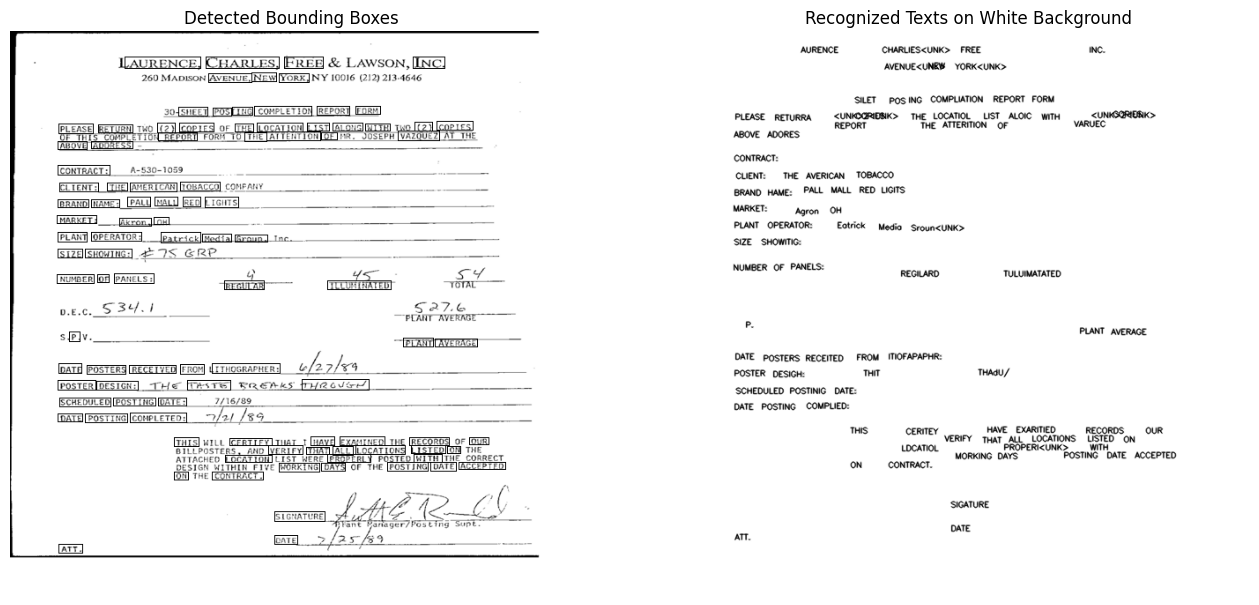


=== Testing Image 1 ===


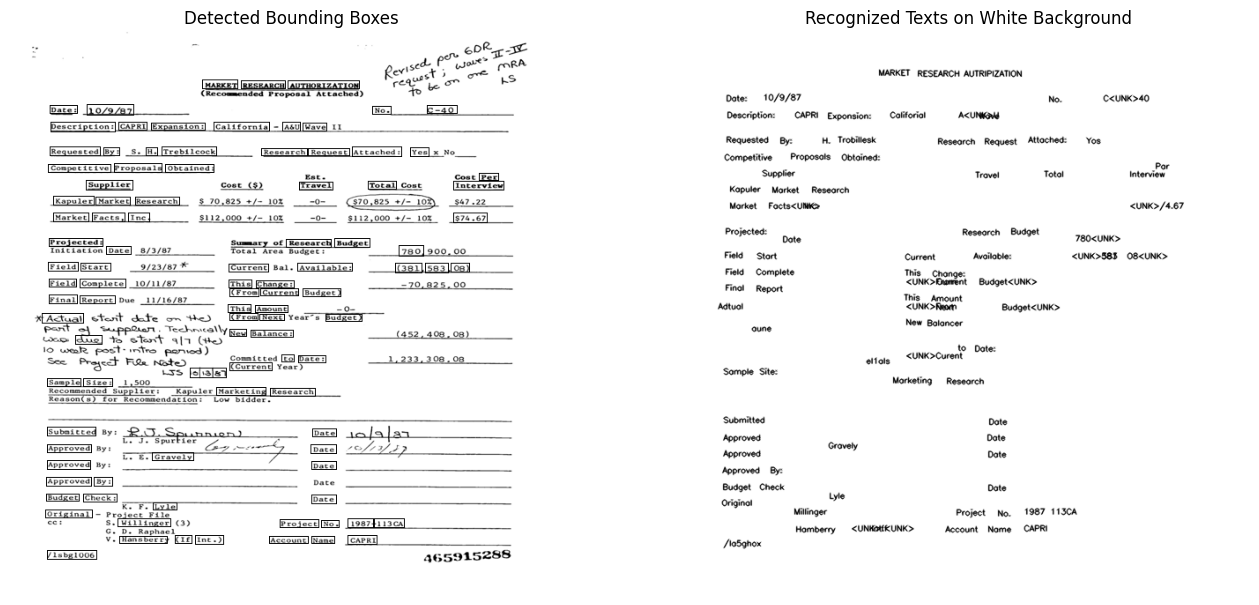


=== Testing Image 2 ===


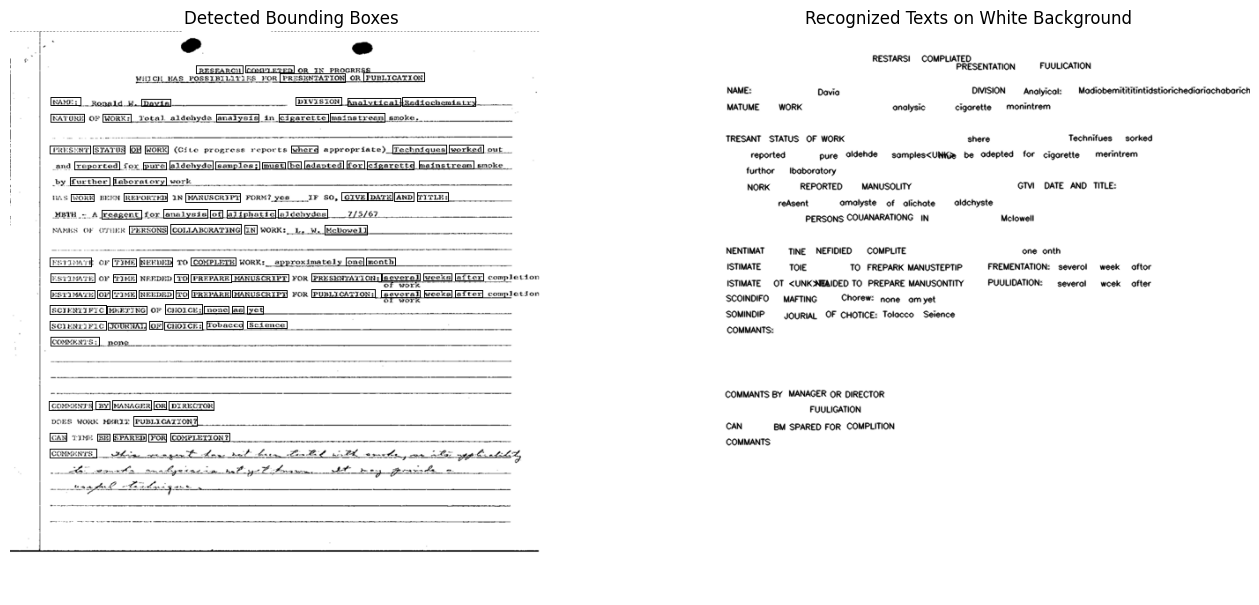


=== Testing Image 3 ===


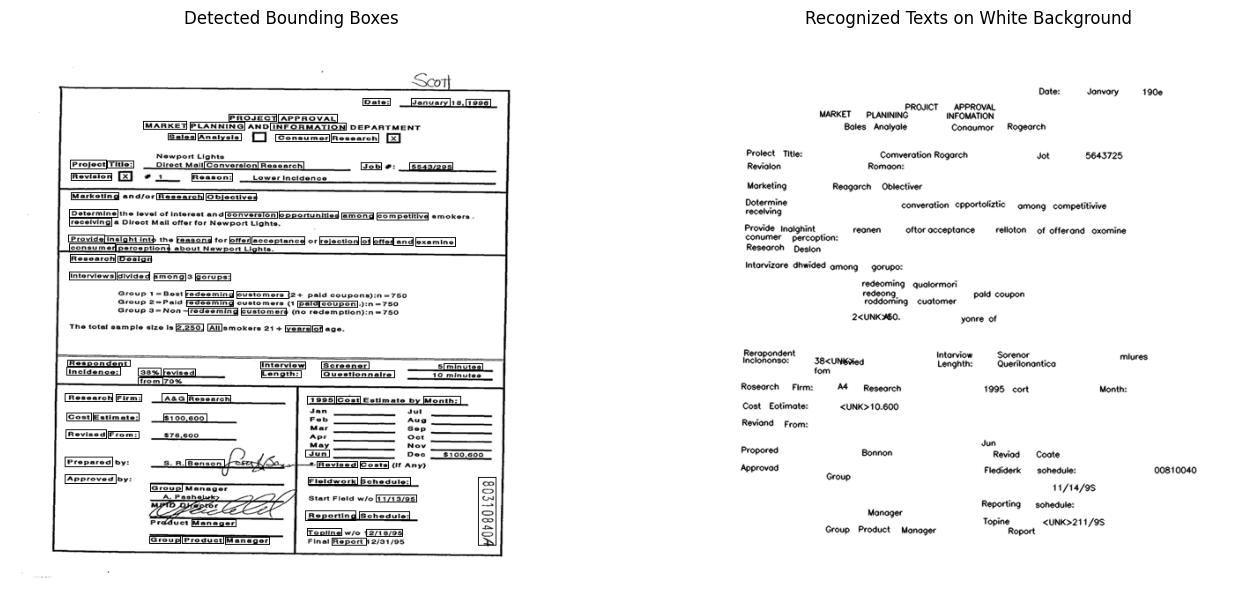


=== Testing Image 4 ===


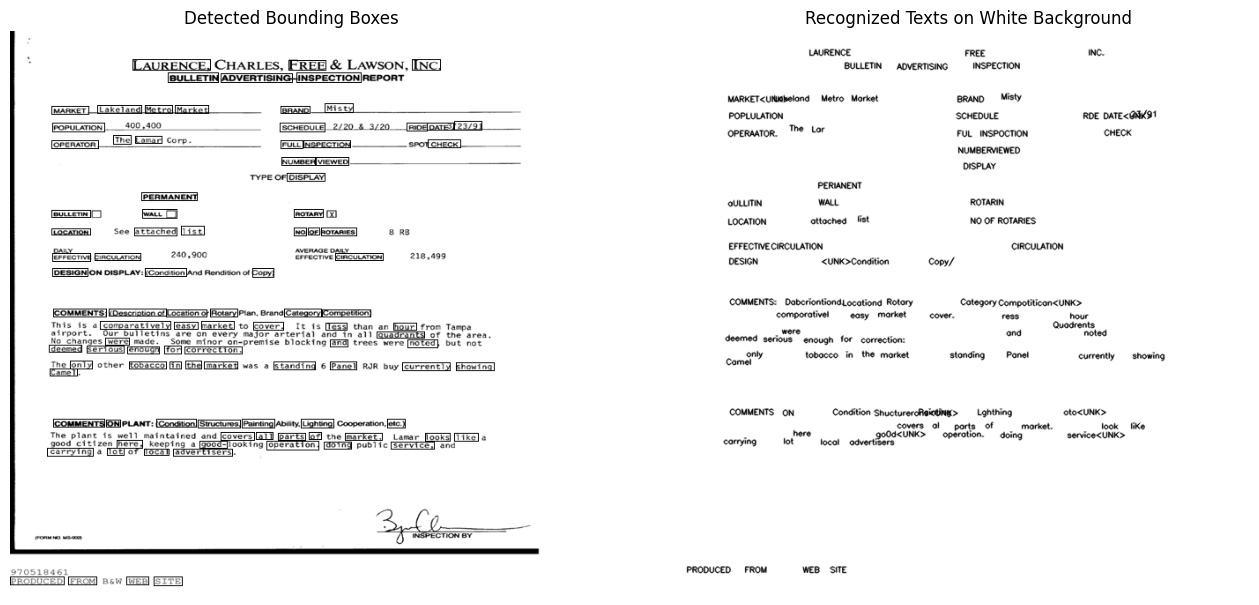

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

detect_model = TextDetectorModel(num_classes=2)
detect_checkpoint = torch.load("/kaggle/input/funsd_model/pytorch/default/1/funsd_model/det.pt", map_location=device)
detect_model.load_state_dict(detect_checkpoint["model_state_dict"])
detect_model = detect_model.to(device).eval()

vocab_size = len(char2idx)
recognize_model = ImageToTextRecognizer(vocab_size=vocab_size)
recognize_model.load_state_dict(torch.load("/kaggle/input/funsd_model/pytorch/default/1/funsd_model/reg_2.pt", map_location=device))
recognize_model = recognize_model.to(device).eval()

for idx in range(5):
    image, target = test_det_dataset[idx] 

    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)

    print(f"\n=== Testing Image {idx} ===")

    results = run_ocr_pipeline_from_image(
        image=image,
        char2idx=char2idx,
        idx2char=idx2char,
        detect_threshold=0.5,
        detect_model=detect_model,
        recognize_model=recognize_model
    )

    gt_texts = target['labels']  
    gt_boxes = target['boxes']  

    for r_idx, r in enumerate(results):
        pred_text = r['text']
        pred_box = r['box']
        pred_size = r['size']

# Evaluation

## Detection 

In [69]:

# metric_map = MeanAveragePrecision(iou_thresholds=list(np.linspace(0.5, 0.95, 10)))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# detect_model = detect_model.to(device).eval()
# n_samples = len(test_det_dataset)

# for idx in range(n_samples):
#     img, target = test_det_dataset[idx]

#     if isinstance(img, torch.Tensor):
#         img = img.to(device)
#     else:
#         img = T.ToTensor()(img).unsqueeze(0).to(device)

#     gt_boxes = target['boxes'].to(device)
#     gt_labels = target['labels'].to(device)

#     if img.dim() == 3:
#         img = img.unsqueeze(0)

#     with torch.no_grad():
#         outputs = detect_model(img)

#     pred = outputs[0]
#     pred_boxes = pred['boxes']
#     pred_scores = pred['scores']
#     pred_labels = pred.get('labels', torch.ones_like(pred_scores, dtype=torch.long))

#     metric_map.update(
#         preds=[{
#             "boxes": pred_boxes.cpu(),
#             "scores": pred_scores.cpu(),
#             "labels": pred_labels.cpu()
#         }],
#         target=[{
#             "boxes": gt_boxes.cpu(),
#             "labels": gt_labels.cpu()
#         }]
#     )

# final_metrics = metric_map.compute()

# print("\n=== Detection Evaluation Results ===")
# print(f"mAP@0.5     : {final_metrics['map_50']:.4f}")
# print(f"mAP@[0.5:.95]: {final_metrics['map']:.4f}")



=== Detection Evaluation Results ===
mAP@0.5     : 0.5436
mAP@[0.5:.95]: 0.2760


## Regconization

In [77]:
def sequence_to_text(seq, idx2char):
    tokens = []
    for idx in seq:
        char = idx2char.get(idx.item(), "")
        if char in ["<SOS>", "<EOS>", "<PAD>"]:
            continue
        tokens.append(char)
    return ''.join(tokens)

def compute_cer(pred_text, gt_text):
    if len(gt_text) == 0:
        return 1.0 if len(pred_text) > 0 else 0.0
    dist = editdistance.eval(pred_text.strip(), gt_text.strip())
    return dist / len(gt_text)

def compute_exact_match(pred_text, gt_text):
    return int(pred_text.strip() == gt_text.strip())

def evaluate_recognition_model(model, test_dataset, char2idx, idx2char, device="cuda"):
    model = model.to(device).eval()
    total_cer = 0
    total_wer = 0
    total_em = 0
    n_samples = len(test_dataset)

    for idx in range(n_samples):
        img, label_seq = test_dataset[idx]

        img = img.to(device)

        tgt_input = label_seq.unsqueeze(0).to(device)[:, :-1]  
        tgt_output = label_seq.unsqueeze(0).to(device)[:, 1:]

        with torch.no_grad():
            logits = model(img.unsqueeze(0), tgt_input)

        pred_seq = logits.argmax(-1) 

        pred_text = sequence_to_text(pred_seq[0], idx2char)
        gt_text = sequence_to_text(tgt_output[0], idx2char)

        cer = compute_cer(pred_text, gt_text)
        em = compute_exact_match(pred_text, gt_text)
        wer_val = wer(gt_text.strip(), pred_text.strip())

        total_cer += cer
        total_wer += wer_val
        total_em += em

    avg_cer = total_cer / n_samples
    avg_wer = total_wer / n_samples
    exact_match = total_em / n_samples

    print("\n=== Recognition Evaluation Results ===")
    print(f"CER (Character Error Rate): {avg_cer:.4f}")
    print(f"WER (Word Error Rate)     : {avg_wer:.4f}")
    print(f"Exact Match Accuracy       : {exact_match:.4f}")

    # return {
    #     "cer": avg_cer,
    #     "wer": avg_wer,
    #     "exact_match": exact_match
    # }


In [78]:
# evaluate_recognition_model(
#     model=recognize_model,
#     test_dataset=test_reg_dataset,
#     char2idx=char2idx,
#     idx2char=idx2char,
#     device="cuda"
# )



=== Recognition Evaluation Results ===
CER (Character Error Rate): 0.1616
WER (Word Error Rate)     : 0.3163
Exact Match Accuracy       : 0.6837
